# Music Data Harmonization

#### The Goal:
Collect artist discography data for analysis in bedroom pop genre. This includes artist names, full discography, and song metadata, like streams, release date, and lyrics.

#### The Problem:
There are two primary datasources. LastFM has artist discography data and some song metadata readily available, which I have already scraped.
Lyric data can be scraped from AZLyrics, but there is no easy way to query artist names given our LastFM data source. Some artist names have different abbreviations, or certain songs may include additional featured artists or version types making it difficult to match artist and songs across data sources.

#### The Soltuion:
Create training corpus and represent features in so that we can match discography data to the lyric data.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import math
from urllib.parse import unquote
import pickle
import warnings
warnings.filterwarnings('ignore')

## Load Discography Data

In [2]:
file_names = [
    "album_tracks_3_20231014_190058.pkl"
]

data_parts = []

for file_name in file_names:
    with open(file_name, "rb") as file:
        data = pickle.load(file)
        data_parts.append(data)

## Load Lyric Data

In [3]:
df_lyrics = pd.read_csv('g_track_name_with_links.csv')
df_lyrics2 = pd.read_csv('h_track_name_with_links.csv')
df_lyrics3 = pd.read_csv('i_track_name_with_links.csv')

In [4]:
df_lyrics = pd.concat([df_lyrics, df_lyrics2, df_lyrics3], ignore_index=True, sort=False)

In [5]:
df_lyrics['df_source'] = 'lyrics'

In [6]:
df_lyrics = df_lyrics[(df_lyrics.Year != 'Missing') & (df_lyrics.Lyrics_URL != 'Missing')]

df_lyrics = df_lyrics.dropna(how='any', axis=0)

df_lyrics.shape

(93842, 6)

In [7]:
df_lyrics.head()

,Unnamed: 0,Artist_Name,Song_Title,Year,Lyrics_URL,df_source
0,0,G4 Boyz,"Hair, Nails, Makeup",2013,https://www.azlyrics.com/lyrics/g4boyz/hairnai...,lyrics
1,1,G4 Boyz,Bricks,2014,https://www.azlyrics.com/lyrics/g4boyz/bricks....,lyrics
2,2,G4 Boyz,Alexander Wang,2015,https://www.azlyrics.com/lyrics/g4boyz/alexand...,lyrics
3,3,G4 Boyz,Can't Sit With Us,2015,https://www.azlyrics.com/lyrics/g4boyz/cantsit...,lyrics
4,4,G4 Boyz,The African Plug Intro,2017,https://www.azlyrics.com/lyrics/g4boyz/theafri...,lyrics


In [8]:
column_mapping = {
    'Unnamed: 0	': 'Unnamed: 0',
    'Artist_Name': 'artist_name',
    'Song_Title': 'track_name',
    'Year': 'release_date',
    'Lyrics_URL': 'lyrics_url',
    'df_source': 'df_source'
}

df_lyrics = df_lyrics.rename(columns=column_mapping)

Tuples are structured as follows:

([Dict of Track Name, Listeners], {Dict of album meta data, track length, release data, listeners, plays, album length, artist name}]

#### Truncating to include only albums with 4 or more tracks.

In [9]:
filtered_albums = [
    album for album in data
    if int(album[1]['Length'].split(' ')[0]) > 3
]

In [10]:
len(filtered_albums)

3628

In [11]:
rows = []

for tracks, metadata in filtered_albums:
    for track in tracks:
        observation = {**track, **metadata}
        rows.append(observation)

df = pd.DataFrame(rows)

df.head()

,name,listeners,Length,Release Date,Listeners,Plays,AlbumName,Artist
0,Gershwin+Says,NaN,"4 tracks, 16:40",10 July 2000,1,1,Strip+-+EP,Gloss
1,Waterdays,NaN,"4 tracks, 16:40",10 July 2000,1,1,Strip+-+EP,Gloss
2,Overnight,NaN,"4 tracks, 16:40",10 July 2000,1,1,Strip+-+EP,Gloss
3,Skin+(Stripped+Version),NaN,"4 tracks, 16:40",10 July 2000,1,1,Strip+-+EP,Gloss
4,Gershwin+Says,NaN,"4 tracks, 16:40",10 July 2000,1,1,Strip+-+EP,Gloss


In [12]:
column_mapping = {
    'name': 'track_name',
    'listeners': 'track_listeners',
    'Length': 'album_length',
    'Release Date': 'release_date',
    'Listeners': 'album_listeners',
    'Plays': 'album_streams',
    'AlbumName': 'album_name',
    'Artist': 'artist_name'
}

df = df.rename(columns=column_mapping)

In [13]:
unique_artists_count = df['artist_name'].nunique()
print(unique_artists_count)

415


In [14]:
df['df_source'] = 'disc'

In [15]:
df.columns

Index(['track_name', 'track_listeners', 'album_length', 'release_date',
       'album_listeners', 'album_streams', 'album_name', 'artist_name',
       'df_source'],
      dtype='object')

## Data Cleaning

In [16]:
def convert_to_int(val):
    try:
        return int(str(val).replace(',', ''))
    except ValueError:
        return 0

df['album_streams'] = df['album_streams'].apply(convert_to_int)

In [17]:
df.sort_values(by='album_streams', ascending=False).head()

,track_name,track_listeners,album_length,release_date,album_listeners,album_streams,album_name,artist_name,df_source
4349,Eight,NaN,"13 tracks, 46:51",20 February 2012,"1,295,985",45723760,Visions,Grimes,disc
4353,Be+a+Body+(%E4%BE%98%E5%AF%82),NaN,"13 tracks, 46:51",20 February 2012,"1,295,985",45723760,Visions,Grimes,disc
4348,Oblivion,NaN,"13 tracks, 46:51",20 February 2012,"1,295,985",45723760,Visions,Grimes,disc
4347,Genesis,NaN,"13 tracks, 46:51",20 February 2012,"1,295,985",45723760,Visions,Grimes,disc
4346,Infinite+%E2%9D%A4+Without+Fulfillment,NaN,"13 tracks, 46:51",20 February 2012,"1,295,985",45723760,Visions,Grimes,disc


In [18]:
df_lyrics.loc[df_lyrics['artist_name'] == 'Hector Gachan', 'artist_name'] = 'Gachan, Hector'
df_lyrics.loc[df_lyrics['artist_name'] == "Her's", 'artist_name'] = 'Hers'

In [21]:
df = pd.concat([df, df_lyrics], ignore_index=True, sort=False)

## Text Preprocessing

In [22]:
def preprocess_text(text):
    decoded_text = unquote(text)
    decoded_text = decoded_text.lower()
    decoded_text = decoded_text.replace("+", " ")
    return decoded_text

df['track_name'] = df['track_name'].apply(preprocess_text)
df['artist_name'] = df['artist_name'].apply(preprocess_text)

## Save DF

In [25]:
df.to_csv('combined_raw_disc_lyrics.csv', index=False)

### Combining text and creating embeddings matches primarily on track name similarity, does not match artist

In [26]:
df['combined_text'] = df['artist_name'] + " " + df['track_name']

### Artificially inflating artist name frequency matches better on artist name, but too simplisitc.

In [27]:
df['weighted_combined_text'] = df['artist_name'] + " " + df['artist_name'] + " " + df['artist_name'] + " " + df['track_name']

### Let's create seperate embeddings for each artist name and track name. We can then apply custom weighting to artist name if needed.

### This weighted factor of 5 and 2 is arbitrary and should be adjusted for feature weighting.

In [28]:
artists_disc = df[df['df_source'] == 'disc']['artist_name'].value_counts()
eligible_artists_disc = artists_disc[artists_disc >= 10].index

filtered_disc = df[(df['df_source'] == 'disc') & (df['artist_name'].isin(eligible_artists_disc))]
subset_disc = filtered_disc.groupby('artist_name').sample(n=10, random_state=42)

In [29]:
artists_lyrics = df[df['df_source'] == 'lyrics']['artist_name'].value_counts()
eligible_artists_lyrics = artists_lyrics[artists_lyrics >= 10].index

filtered_lyrics = df[(df['df_source'] == 'lyrics') & (df['artist_name'].isin(eligible_artists_lyrics))]
subset_lyrics = filtered_lyrics.groupby('artist_name').sample(n=10, random_state=42)

In [30]:
df = pd.concat([subset_disc, subset_lyrics])

## Embedding Creation w2v

In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

df['tokens'] = df['weighted_combined_text'].apply(word_tokenize)

model_w2v = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4)
model_w2v.save("word2vec.model")

def get_avg_vector(tokens, model):
    return np.mean([model.wv[t] for t in tokens if t in model.wv.index_to_key], axis=0)

df['w2v_embedding'] = df['tokens'].apply(lambda x: get_avg_vector(x, model_w2v))

## Embedding Creation DistilBERT

In [31]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

def get_transformer_embedding(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

df['artist_transformer_embedding'] = df['artist_name'].apply(lambda x: get_transformer_embedding(x, tokenizer, model))
df['track_transformer_embedding'] = df['track_name'].apply(lambda x: get_transformer_embedding(x, tokenizer, model))

## Save/Load Embeddings

In [32]:
df['artist_transformer_embedding'] = df['artist_transformer_embedding'].apply(lambda x: ','.join(map(str, x)))
df['track_transformer_embedding'] = df['track_transformer_embedding'].apply(lambda x: ','.join(map(str, x)))

df.to_parquet('embedded_songs_and_tracks_sampled.parquet')

In [33]:
def string_to_array(embedding_str):
    embedding_str = embedding_str.replace('[', '').replace(']', '')
    return np.fromstring(embedding_str, sep=' ')

df = pd.read_parquet('embedded_songs_and_tracks_sampled.parquet')
df['artist_transformer_embedding'] = df['artist_transformer_embedding'].apply(string_to_array)
df['track_transformer_embedding'] = df['track_transformer_embedding'].apply(string_to_array)

## Similarity Computaiton

## Weighted Combination of Embeddings

In [34]:
from sklearn.metrics.pairwise import cosine_similarity

artist_weight = 0.7
track_weight = 0.3

df['combined_embedding'] = df.apply(lambda row: artist_weight * row['artist_transformer_embedding'] + track_weight * row['track_transformer_embedding'], axis=1)

similarity_matrix_combined = cosine_similarity(np.array(df['combined_embedding'].tolist()))

## Dim Reduction W2V

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA

data = np.array(df['w2v_embedding'].tolist())

pca = PCA(n_components=20)
pca.fit(data)

explained_variances = pca.explained_variance_ratio_
plt.figure(figsize=(10, 5))
plt.plot(explained_variances, 'o-')
plt.xlabel('Component Number')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Component (up to 20 components)')
plt.show()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
reduced_pca = pca.fit_transform(np.array(df['w2v_embedding'].tolist()))

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
reduced_tsne = tsne.fit_transform(reduced_pca)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.scatter(reduced_tsne[:, 0], reduced_tsne[:, 1], s=70, alpha=0.7)
plt.title('t-SNE visualization of w2v embeddings')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

range_n_clusters = list(range(2,21))

silhouette_scores = [] 

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(reduced_pca)
    
    silhouette_avg = silhouette_score(reduced_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, 'o-')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different Numbers of Clusters")
plt.show()

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_pca)

plt.figure(figsize=(12, 8))
for i in range(n_clusters):
    plt.scatter(reduced_tsne[cluster_labels == i, 0], 
                reduced_tsne[cluster_labels == i, 1], 
                label=f"Cluster {i}", 
                s=70, 
                alpha=0.7)
plt.title('t-SNE visualization of w2v embeddings with K-means clustering')
plt.legend()
plt.show()

## Dim Reduction BERT

In [35]:
similarity_matrix_transformer = similarity_matrix_combined

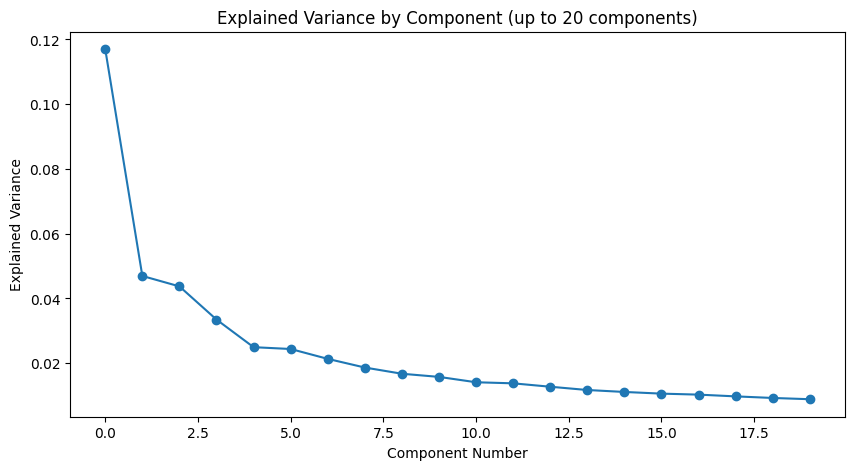

In [36]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA

data = np.array(df['combined_embedding'].tolist())

pca = PCA(n_components=20)
pca.fit(data)

explained_variances = pca.explained_variance_ratio_
plt.figure(figsize=(10, 5))
plt.plot(explained_variances, 'o-')
plt.xlabel('Component Number')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Component (up to 20 components)')
plt.show()

## Model Training and Prediction

In [37]:
pca = PCA(n_components=8)
reduced_pca = pca.fit_transform(np.array(df['combined_embedding'].tolist()))

In [38]:
from sklearn.manifold import TSNE

In [39]:
tsne = TSNE(n_components=2, random_state=42)
reduced_tsne = tsne.fit_transform(reduced_pca)

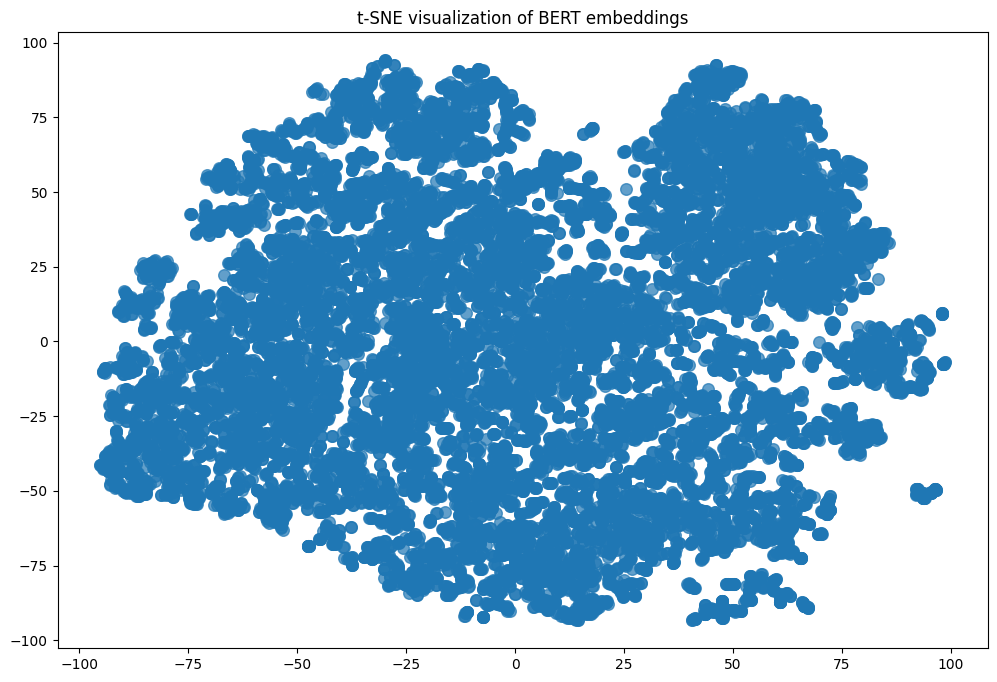

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.scatter(reduced_tsne[:, 0], reduced_tsne[:, 1], s=70, alpha=0.7)
plt.title('t-SNE visualization of BERT embeddings')
plt.show()

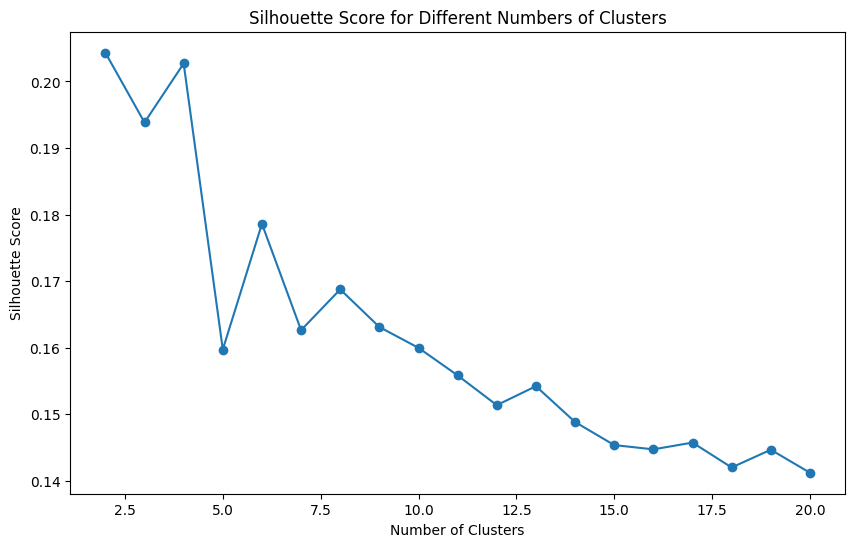

In [41]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

range_n_clusters = list(range(2,21))

silhouette_scores = [] 

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(reduced_pca)
    
    silhouette_avg = silhouette_score(reduced_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, 'o-')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different Numbers of Clusters")
plt.show()

## Similarity Computation

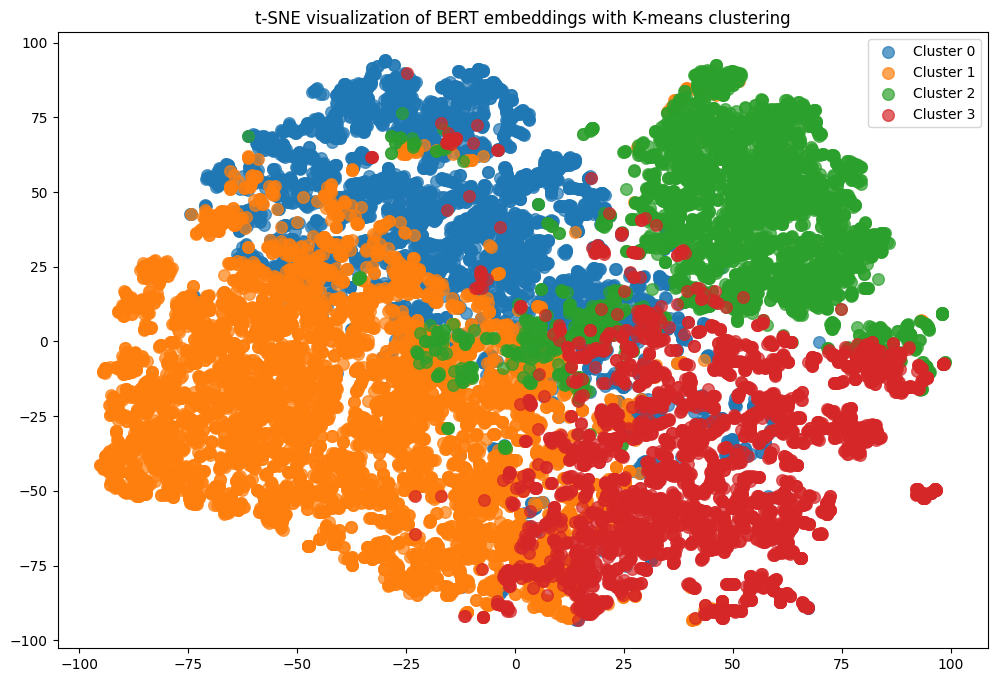

In [42]:
from sklearn.cluster import KMeans

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_pca)

plt.figure(figsize=(12, 8))
for i in range(n_clusters):
    plt.scatter(reduced_tsne[cluster_labels == i, 0], 
                reduced_tsne[cluster_labels == i, 1], 
                label=f"Cluster {i}", 
                s=70, 
                alpha=0.7)
plt.title('t-SNE visualization of BERT embeddings with K-means clustering')
plt.legend()
plt.show()

## Single Sample Similarity Computation

In [ ]:
sample_record = df.sample(1)
sample_embedding_w2v = sample_record['w2v_embedding'].values[0]
sample_embedding = sample_record['transformer_embedding'].values[0]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

all_embeddings_w2v = np.array(df['w2v_embedding'].tolist())
similarity_scores_w2v = cosine_similarity([sample_embedding_w2v], all_embeddings_w2v)

In [ ]:
threshold_w2v = .9994
matches_w2v = np.where(similarity_scores_w2v > threshold_w2v)[1]

In [ ]:
matched_records_w2v = df.iloc[matches_w2v]
matched_scores_w2v = similarity_scores_w2v[0][matches_w2v]

len(matched_records_w2v)

In [ ]:
sample_record

In [ ]:
matched_records_w2v

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

all_embeddings = np.array(df['transformer_embedding'].tolist())
similarity_scores = cosine_similarity([sample_embedding], all_embeddings)

In [ ]:
threshold = 0.85
matches = np.where(similarity_scores > threshold)[1]

In [ ]:
matched_records = df.iloc[matches]
matched_scores = similarity_scores[0][matches]

matched_records

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def inspect_sample(df, threshold, embedding_column='transformer_embedding'):
    sample_record = df.sample(1)
    sample_embedding = sample_record[embedding_column].values[0]
    
    all_embeddings = np.array(df[embedding_column].tolist())
    similarity_scores = cosine_similarity([sample_embedding], all_embeddings)

    matches = np.where(similarity_scores > threshold)[1]
    matched_records = df.iloc[matches]
    matched_scores = similarity_scores[0][matches]

    same_artist_ratio = np.mean(matched_records['artist_name'] == sample_record['artist_name'].values[0])
    same_album_ratio = np.mean(matched_records['album_name'] == sample_record['album_name'].values[0])
    
    print("Sampled Record:\n", sample_record[['track_name', 'artist_name', 'album_name']])
    print("\nMatched Records:\n", matched_records[['track_name', 'artist_name', 'album_name']])
    print("\nMatched Scores:\n", matched_scores)
    print(f"\nSame Artist Ratio: {same_artist_ratio:.2f}")
    print(f"Same Album Ratio: {same_album_ratio:.2f}")
    
    return matched_records, matched_scores

for _ in range(5):
    print("="*50)
    matched_records, matched_scores = inspect_sample(df, threshold=0.88)

In [ ]:
def inspect_sample(df, threshold, embedding_column='transformer_embedding'):
    sample_record = df.sample(1)
    sample_embedding = sample_record[embedding_column].values[0]
    all_embeddings = np.array(df[embedding_column].tolist())
    similarity_scores = cosine_similarity([sample_embedding], all_embeddings)
    matches = np.where(similarity_scores > threshold)[1]
    matched_records = df.iloc[matches]
    
    same_artist_ratio = np.mean(matched_records['artist_name'] == sample_record['artist_name'].values[0])
    same_album_ratio = np.mean(matched_records['album_name'] == sample_record['album_name'].values[0])
    
    sample_album = sample_record['album_name'].values[0]
    total_songs_in_sample_album = df[df['album_name'] == sample_album].shape[0]
    matched_songs_from_sample_album = matched_records[matched_records['album_name'] == sample_album].shape[0]
    album_song_coverage = matched_songs_from_sample_album / total_songs_in_sample_album
    
    return same_artist_ratio, same_album_ratio, album_song_coverage

thresholds = np.linspace(0.80, 0.99, 20) 
results = []

for threshold in thresholds:
    artist_ratios = []
    album_ratios = []
    album_song_coverages = []
    for _ in range(30):
        artist_ratio, album_ratio, album_coverage = inspect_sample(df, threshold)
        artist_ratios.append(artist_ratio)
        album_ratios.append(album_ratio)
        album_song_coverages.append(album_coverage)
    
    avg_artist_ratio = np.mean(artist_ratios)
    avg_album_ratio = np.mean(album_ratios)
    avg_album_song_coverage = np.mean(album_song_coverages)
    results.append((threshold, avg_artist_ratio, avg_album_ratio, avg_album_song_coverage))
    print(f"Threshold: {threshold:.2f} | Avg Same Artist Ratio: {avg_artist_ratio:.2f} | Avg Same Album Ratio: {avg_album_ratio:.2f} | Avg Album Song Coverage: {avg_album_song_coverage:.2f}")

results_df = pd.DataFrame(results, columns=['Threshold', 'Avg Same Artist Ratio', 'Avg Same Album Ratio', 'Avg Album Song Coverage'])
results_df

## Find Best Matches

In [49]:
def find_best_lyric_matches(df, sample_record, num_matches=5, embedding_column='combined_embedding'):
    lyrics_df = df[df['df_source'] == 'lyrics']
    sample_embedding = sample_record[embedding_column].values[0]
    all_lyric_embeddings = np.array(lyrics_df[embedding_column].tolist())
    
    similarity_scores = cosine_similarity([sample_embedding], all_lyric_embeddings)[0]
    
    top_match_indices = np.argsort(similarity_scores)[-num_matches:][::-1] 
    top_similarity_scores = similarity_scores[top_match_indices]
    
    matching_records = lyrics_df.iloc[top_match_indices]
    
    artists = matching_records['artist_name'].values
    tracks = matching_records['track_name'].values
    sources = matching_records['df_source'].values  
    
    return artists, tracks, sources, top_similarity_scores

def sample_and_match_for_all_artists(df, num_matches=1, similarity_threshold=0.97):
    unique_artists = df[df['df_source'] == 'disc']['artist_name'].unique()
    
    for artist in unique_artists:
        sample_record = df[(df['df_source'] == 'disc') & (df['artist_name'] == artist)].sample(1)
        
        matched_artists, matched_tracks, matched_sources, similarity_scores = find_best_lyric_matches(df, sample_record, num_matches)
        
        if all(score >= similarity_threshold for score in similarity_scores):
            print(f"Sampled Artist: {sample_record['artist_name'].values[0]} | Sampled Track: {sample_record['track_name'].values[0]} | Source: {sample_record['df_source'].values[0]}")
            for i in range(num_matches):
                print(f"  Match {i+1}: Lyric Artist: {matched_artists[i]} | Matched Track: {matched_tracks[i]} | Source: {matched_sources[i]} | Similarity: {similarity_scores[i]:.2f}")
            print("---------------------------------------------------------------------------------")

sample_and_match_for_all_artists(df, similarity_threshold = 0.96)

Sampled Artist: good morning | Sampled Track: to be won | Source: disc
  Match 1: Lyric Artist: good morning | Matched Track: to be won | Source: lyrics | Similarity: 1.00
---------------------------------------------------------------------------------
Sampled Artist: goth babe | Sampled Track: wasted time | Source: disc
  Match 1: Lyric Artist: goth babe | Matched Track: end summer | Source: lyrics | Similarity: 0.98
---------------------------------------------------------------------------------
Sampled Artist: great good fine ok | Sampled Track: change | Source: disc
  Match 1: Lyric Artist: great good fine ok | Matched Track: touch | Source: lyrics | Similarity: 0.98
---------------------------------------------------------------------------------
Sampled Artist: gregory and the hawk | Sampled Track: stuck like glue | Source: disc
  Match 1: Lyric Artist: gregory and the hawk | Matched Track: tin can ride | Source: lyrics | Similarity: 0.97
---------------------------------------

In [50]:
sample_and_match_for_all_artists(df, similarity_threshold = 0.9)

Sampled Artist: gloss | Sampled Track: gershwin says | Source: disc
  Match 1: Lyric Artist: gratitude | Matched Track: sadie | Source: lyrics | Similarity: 0.94
---------------------------------------------------------------------------------
Sampled Artist: glowfriends | Sampled Track: distance two | Source: disc
  Match 1: Lyric Artist: gfriend | Matched Track: only 1 | Source: lyrics | Similarity: 0.92
---------------------------------------------------------------------------------
Sampled Artist: glue trip | Sampled Track: birds singing lies | Source: disc
  Match 1: Lyric Artist: ghost atlas | Matched Track: wet noose | Source: lyrics | Similarity: 0.92
---------------------------------------------------------------------------------
Sampled Artist: glüme | Sampled Track: porcelain | Source: disc
  Match 1: Lyric Artist: glorilla | Matched Track: intro | Source: lyrics | Similarity: 0.93
---------------------------------------------------------------------------------
Sampled Ar